In [ ]:
# Install packages
!pip3 install torch torchvision
# install matplotlib
!pip3 install matplotlib
!pip3 install --upgrade pip

Python(33202) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(33203) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


Python(33204) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
# Import packages

from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
#import wandb
import os
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [41]:
# Create class to load in and transform the data

class CloudRemovalDataset(Dataset):
    def __init__(self, cloudy_dir, clear_dir, image_size=256):
        self.cloudy_dir = cloudy_dir
        self.clear_dir = clear_dir
        self.image_size = image_size

        self.filenames = sorted(os.listdir(cloudy_dir))  # assuming same names in both folders

        # Limit number of filenames to 1000 for debugging
        self.filenames = self.filenames[:100]

        self.transform = T.Compose([
            T.ToTensor(),  # assumes HWC float32 array
            T.Resize((image_size, image_size)),
            T.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        cloudy_path = os.path.join(self.cloudy_dir, fname)
        clear_path = os.path.join(self.clear_dir, fname)

        # Load .npy arrays (assumed shape: H x W x 3, dtype float32 or uint8)
        cloudy_np = np.load(cloudy_path)
        clear_np = np.load(clear_path)

        # Convert to float32 if not already
        if cloudy_np.dtype != np.float32:
            cloudy_np = cloudy_np.astype(np.float32) / 255.0
        if clear_np.dtype != np.float32:
            clear_np = clear_np.astype(np.float32) / 255.0

        # Convert to tensor and normalize
        cloudy = self.transform(cloudy_np)
        clear = self.transform(clear_np)

        return {"cloudy": cloudy, "clear": clear}


In [42]:
def timestep_embedding(timesteps, dim):
    # sinusoidal embedding
    device = timesteps.device
    half_dim = dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if dim % 2 == 1:  # zero pad
        emb = F.pad(emb, (0, 1, 0, 0))
    return emb

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
        )
        self.time_embed = nn.Sequential(
            nn.Linear(embed_dim, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels)
        )

    def forward(self, x, t):
        h = self.double_conv(x)
        t_emb = self.time_embed(t).view(t.shape[0], -1, 1, 1)
        return h + t_emb

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim)

    def forward(self, x, t):
        return self.conv(self.pool(x), t)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, embed_dim)

    def forward(self, x1, x2, t):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1), t)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, cond_channels=3, base_channels=64, embed_dim=256):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_conv = DoubleConv(in_channels + cond_channels, base_channels, embed_dim)
        self.down1 = Down(base_channels, base_channels * 2, embed_dim)
        self.down2 = Down(base_channels * 2, base_channels * 4, embed_dim)
        self.up1 = Up(base_channels * 4, base_channels * 2, embed_dim)
        self.up2 = Up(base_channels * 2, base_channels, embed_dim)
        self.output_conv = nn.Conv2d(base_channels, in_channels, 1)

    def forward(self, x, cond, t):
        t_emb = timestep_embedding(t, self.embed_dim)
        x = torch.cat([x, cond], dim=1)
        x1 = self.input_conv(x, t_emb)
        x2 = self.down1(x1, t_emb)
        x3 = self.down2(x2, t_emb)
        x = self.up1(x3, x2, t_emb)
        x = self.up2(x, x1, t_emb)
        return self.output_conv(x)


In [43]:
# Define scheduler 

class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise


In [44]:
# --- Config ---
config = {
    "epochs": 3,
    "batch_size": 8,
    "lr": 1e-4,
    "timesteps": 1000,
    "image_size": 256,
    "device": "mps" if torch.backends.mps.is_available() else "cpu"
}

#wandb.init(project="cloud_removal", config=config)

# --- Load data ---
dataset = CloudRemovalDataset(
    cloudy_dir="/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/cloudy_patches",
    clear_dir="/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/clear_patches",
    image_size=config["image_size"]
)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# --- Init model ---
model = ConditionalUNet().to(config["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])

# --- Denoising function ---
def p_sample_loop(model, scheduler, shape, cond, device):
    x = torch.randn(shape).to(device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)
        noise_pred = model(x, cond, t_batch)

        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_cumprod_t = scheduler.alpha_cumprod[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * noise_pred) + torch.sqrt(beta_t) * noise
    return x

# --- Training loop ---
train_losses = []
test_losses = []

for epoch in range(config["epochs"]):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        cloudy = batch["cloudy"].to(config["device"])
        clear = batch["clear"].to(config["device"])

        t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
        noise = torch.randn_like(cloudy)
        noisy_cloudy = scheduler.q_sample(cloudy, t, noise)

        pred_noise = model(noisy_cloudy, clear, t)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            cloudy = batch["cloudy"].to(config["device"])
            clear = batch["clear"].to(config["device"])
            t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
            noise = torch.randn_like(cloudy)
            noisy_cloudy = scheduler.q_sample(cloudy, t, noise)
            pred_noise = model(noisy_cloudy, clear, t)
            test_loss = F.mse_loss(pred_noise, noise)
            running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Train Epoch 1: 100%|██████████| 12/12 [01:39<00:00,  8.33s/it]


[Epoch 1] Train Loss: 1.0413, Test Loss: 1.0152


Train Epoch 2: 100%|██████████| 12/12 [03:03<00:00, 15.29s/it]


[Epoch 2] Train Loss: 1.0085, Test Loss: 1.0049


Train Epoch 3: 100%|██████████| 12/12 [07:47<00:00, 38.92s/it]


[Epoch 3] Train Loss: 1.0052, Test Loss: 1.0044


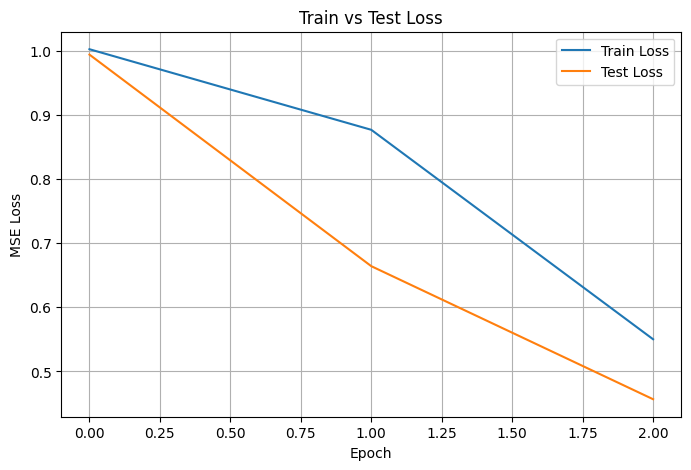

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")
plt.show()


cloudy range: 26.69411849975586 121.29804229736328
clear range: 16.882352828979492 126.14509582519531
denoised range: 26.863433837890625 122.40340423583984


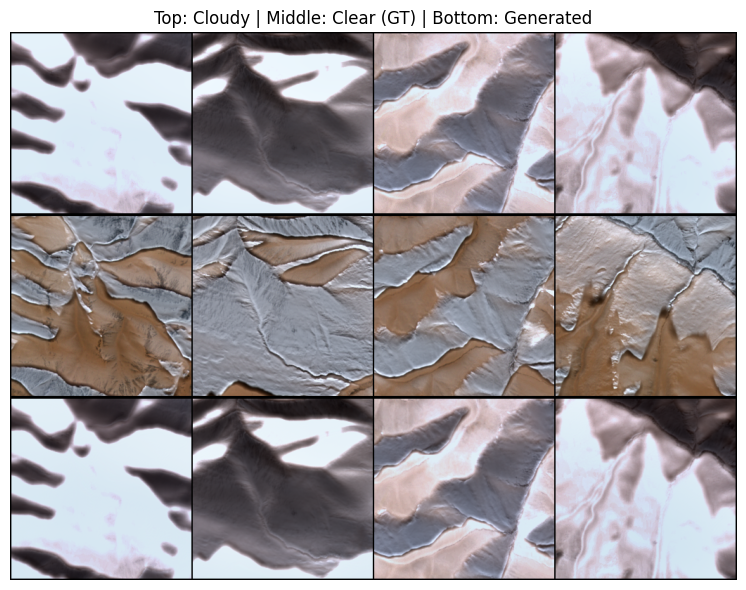

In [ ]:
# Visualize model predictions

def rescale_auto(img):
    vmin = img.min()
    vmax = img.max()
    return (img - vmin) / (vmax - vmin + 1e-8)

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    cloudy = batch["cloudy"].to(config["device"])
    clear = batch["clear"].to(config["device"])

    # Use t=0 for clean output
    t = torch.zeros(cloudy.size(0), dtype=torch.long, device=config["device"])
    noise = torch.randn_like(cloudy)
    noisy_cloudy = scheduler.q_sample(cloudy, t, noise)
    pred_noise = model(noisy_cloudy, clear)
    denoised = noisy_cloudy - pred_noise  # simple one-step denoise

    # Rescale from [-1, 1] to [0, 1]
    def rescale(img): return (img.clamp(-1, 1) + 1) / 2

    # Select only the first 4 examples for clearer plotting
    cloudy_vis = rescale_auto(cloudy[:4].cpu())
    clear_vis = rescale_auto(clear[:4].cpu())
    denoised_vis = rescale_auto(denoised[:4].cpu())

    # Create one row per type
    cloudy_row = vutils.make_grid(cloudy_vis, nrow=4, padding=2)
    clear_row = vutils.make_grid(clear_vis, nrow=4, padding=2)
    denoised_row = vutils.make_grid(denoised_vis, nrow=4, padding=2)

    # Stack vertically (C, H * 3, W)
    full_grid = torch.cat([cloudy_row, clear_row, denoised_row], dim=1)

    print("cloudy range:", cloudy.min().item(), cloudy.max().item())
    print("clear range:", clear.min().item(), clear.max().item())
    print("denoised range:", denoised.min().item(), denoised.max().item())

    # Plot
    plt.figure(figsize=(16, 6))
    plt.imshow(full_grid.permute(1, 2, 0))  # C×H×W → H×W×C
    plt.title("Top: Cloudy | Middle: Clear (GT) | Bottom: Generated")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


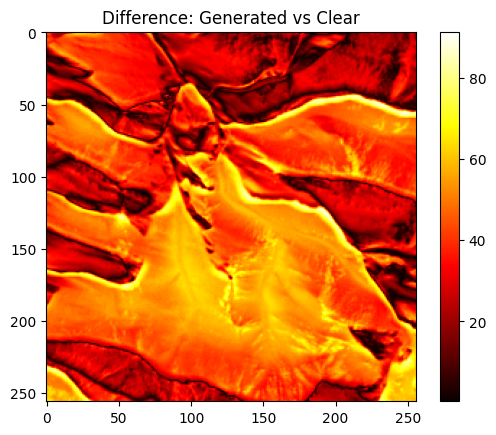

In [40]:
diff = (denoised - clear).abs().mean(dim=1, keepdim=True)  # per-pixel error map
plt.imshow(diff[0].cpu().squeeze(), cmap='hot')
plt.title("Difference: Generated vs Clear")
plt.colorbar()
plt.show()

In [ ]:
# Generate and visualize sample output

# Takes forever -- need to revisit

with torch.no_grad():
    batch = next(iter(test_loader))
    cond = batch["clear"].to(config["device"])
    gen = p_sample_loop(model, scheduler, shape=cond.shape, cond=cond, device=config["device"])

    vis = torch.cat([
        rescale_auto(batch["cloudy"][:1].cpu()),
        rescale_auto(batch["clear"][:1].cpu()),
        rescale_auto(gen[:1].cpu())
    ], dim=0)

    grid = make_grid(vis, nrow=2)
    plt.figure(figsize=(12, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Top: Cloudy | Middle: Clear | Bottom: Generated")
    plt.show()


KeyboardInterrupt: 

In [ ]:
# To Do List

# Make sure model/loop makes sense
# Figure out better loss function (maybe using cloud mask)
# Add wandb logging
# Why is diffusion model getting slower over time

In [ ]:
# Previous script

"""
# Construct model classes 

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(1, out_channels),
            nn.GELU(),
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1))

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, cond_channels=3, base_channels=64):
        super().__init__()
        self.input_block = DoubleConv(in_channels + cond_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.up1 = Up(base_channels * 4, base_channels * 2)
        self.up2 = Up(base_channels * 2, base_channels)
        self.output_block = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, cond):
        # Concatenate cloudy (x) and clear (cond) images
        x = torch.cat([x, cond], dim=1)
        x1 = self.input_block(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.output_block(x)

# Define scheduler 

class DiffusionScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)

        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.tensor([1.], device=device), self.alpha_cumprod[:-1]])

        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alpha_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alpha_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alpha_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise

# train.py

# --- Config ---
config = {
    "epochs": 3,
    "batch_size": 8,
    "lr": 1e-4,
    "timesteps": 1000,
    "image_size": 256,
    "device": "mps" if torch.backends.mps.is_available() else "cpu"
}

#wandb.init(project="cloud_removal", config=config)

# --- Load data ---
dataset = CloudRemovalDataset(
    cloudy_dir="/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/cloudy_patches",
    clear_dir="/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/clear_patches",
    image_size=config["image_size"]
)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

# --- Init model ---
model = ConditionalUNet().to(config["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
scheduler = DiffusionScheduler(timesteps=config["timesteps"], device=config["device"])

# --- Training loop ---
train_losses = []
test_losses = []

for epoch in range(config["epochs"]):
    model.train()
    running_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        cloudy = batch["cloudy"].to(config["device"])
        clear = batch["clear"].to(config["device"])

        t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
        noise = torch.randn_like(cloudy)
        noisy_cloudy = scheduler.q_sample(cloudy, t, noise)

        pred_noise = model(noisy_cloudy, clear)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            cloudy = batch["cloudy"].to(config["device"])
            clear = batch["clear"].to(config["device"])
            t = torch.randint(0, config["timesteps"], (cloudy.size(0),), device=config["device"]).long()
            noise = torch.randn_like(cloudy)
            noisy_cloudy = scheduler.q_sample(cloudy, t, noise)
            pred_noise = model(noisy_cloudy, clear)
            test_loss = F.mse_loss(pred_noise, noise)
            running_test_loss += test_loss.item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
"""